In [252]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import json


def zscore(series):
    return (series - series.mean()) / series.std()


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid(x, k=1, x0=0):
    return 1 / (1 + np.exp(-k * (x - x0)))


def adjusted_sigmoid(x, f_min=0.01, f_max=0.1, k=1, x0=0):
    return f_min + (f_max - f_min) * sigmoid(x, k=k, x0=x0)


def global_sigmoid(x, f_min, f_max, k=1, x0=0):
    if x > 0:
        return adjusted_sigmoid(x, f_min, f_max, k, x0)
    else:
        return adjusted_sigmoid(-x, f_min, f_max, k, x0)
    
    
def calculate_markout(d, v, f, p):
    m = d * v * (f - p)
    return m


data_p1 = pd.read_pickle('data/Merged_CEX_DEX_v2_p1.pkl')
data_p2 = pd.read_pickle('data/Merged_CEX_DEX_v2_p2.pkl')
data_p3 = pd.read_pickle('data/Merged_CEX_DEX_v2_p3.pkl')

data_p1['time'] = pd.to_datetime(data_p1['time'])
data_p2['time'] = pd.to_datetime(data_p2['time'])
data_p3['time'] = pd.to_datetime(data_p3['time'])

data = pd.concat([data_p1, data_p2, data_p3])
data = data.rename(columns={'LVR_clean': 'price_diff', 'LVR': 'arb_pnl' })
data = data.sort_values('time')
current_liquidity_usd = 166.31 * 10**6

In [253]:
with open('gas_prices_final.json', 'r') as file:
    gas_price_eth = json.load(file)

data['impermanent_loss'] = (2 * np.sqrt(data['price_dex'].shift(1) / data['price_dex']) / (1 + data['price_dex'].shift(1) / data['price_dex']) - 1).fillna(0)
data['LVR_nbtoken']= data['arb_pnl']/data['price_dex']

data['avg_block_gas'] = data['blockNumber'].astype(str).map(gas_price_eth)
data['avg_gas']    = data['gasUsed'] * data['avg_block_gas'].rolling(20).mean() * data['price_dex']
data['arb_fee']    = (np.abs(2*data['arb_pnl']) - (data['tcost_usd'] - data['avg_gas']))*100 / data['amountUSD']

data['LVR_zscore'] = zscore(data['arb_pnl'])

data['std']             = data['price_dex'].rolling(100).std()
data['mean_rol_amount'] = data['amountUSD'].rolling(10).mean()
data['rol_amountUSD']   = data['amountUSD'].rolling(100).sum()

# can be seen as looking ahead but in a DEX we can compute it aheat with the liquidity and the amount
data['price_impact']    = (data['amount0'].apply(lambda x: (2*x + x**2)/current_liquidity_usd)*100/data['price_dex'])

data['time_diff']          = data['time'].diff().dt.total_seconds().fillna(0)

data['rol_1min_span']      = data['time_diff'].rolling(window=60, min_periods=1).sum() 
data['rol_1m_trade_count'] = data['time'].rolling(window=60, min_periods=1).count()
data['lambda_1min']        = data['rol_1m_trade_count'] / data['rol_1min_span']
data['lambda_1min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)

data['rol_5min_span']      = data['time_diff'].rolling(window=60*5, min_periods=1).sum() 
data['rol_5m_trade_count'] = data['time'].rolling(window=60*5, min_periods=1).count()
data['lambda_5min']        = data['rol_5m_trade_count'] / data['rol_5min_span']
data['lambda_5min'].replace([float('inf'), float('-inf'), pd.NA], 0, inplace=True)
data = data.drop(columns=['time_diff'])

data['target_fee'] = (-np.sign(data['amount1']) * data['arb_fee']/100).clip(-0.1, 0.1)

data = data.dropna()

features = ['LVR_nbtoken', 'price_diff', 'arb_pnl', 'std', 'mean_rol_amount', 'avg_gas', 'price_impact', 'rol_amountUSD',
            'lambda_1min', 'rol_1min_span', 'rol_1m_trade_count', 
            'lambda_5min', 'rol_5min_span', 'rol_5m_trade_count', 'amountUSD']
target =  'target_fee' # 'tcost_usd'

# lower_bound = data[features].quantile(0.05)
# upper_bound = data[features].quantile(0.95)
# filtered_indices = data[features].apply(lambda x: x.between(lower_bound[x.name], upper_bound[x.name])).all(axis=1)
data_filtered = data.copy() # .loc[filtered_indices].copy()

f_min = 0.04
f_max = 0.1
w     = 0.04
k     = 1.75  # Steepness of the curve

params = {}
for f in features:
    params[f] = {'f_min': f_min, 'f_max': f_max, 'k': k, 'x0': (f_max-f_min)/(2*w)}
    
    
data_filtered

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,mean_rol_amount,rol_amountUSD,price_impact,rol_1min_span,rol_1m_trade_count,lambda_1min,rol_5min_span,rol_5m_trade_count,lambda_5min,target_fee
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,31679.388299,3.274054e+06,0.010468,1032.0,60.0,0.058140,1404.0,100.0,0.071225,0.001063
100,-160.477545,0.070000,160.352835,0xea08db5fb88d6f1f4978400ec2c57d9a29e85e99,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xef5edb29b4eb20501de89718daa7d1ad108efb66,1.704069e+09,445316,1.225569e+10,1.225569e-08,...,31196.151489,3.256138e+06,0.000007,1032.0,60.0,0.058140,1404.0,101.0,0.071937,-0.025052
101,-99.931075,0.043590,99.853435,0x5e969b786482489323c94b8abc4eb03a41da527a,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0x5e969b786482489323c94b8abc4eb03a41da527a,1.704069e+09,270277,1.144304e+10,1.144304e-08,...,31203.846347,3.255538e+06,0.000003,1044.0,60.0,0.057471,1428.0,102.0,0.071429,-0.028585
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,20749.062023,3.232065e+06,0.000591,1056.0,60.0,0.056818,1476.0,103.0,0.069783,0.002980
103,-550.210323,0.240000,549.781949,0xcdb343941111e306d71f141689b5b69d07ca6f59,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,306333,1.182152e+10,1.182152e-08,...,20425.349686,3.231848e+06,0.000079,1080.0,60.0,0.055556,1500.0,104.0,0.069333,-0.006118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187222,-2280.293805,1.000000,2280.074254,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,0x1b0cae4374ebc96289d8dab50eeffc20d3528503,1.706746e+09,284804,3.171776e+10,3.171776e-08,...,18890.788832,1.082558e+06,0.001369,1116.0,60.0,0.053763,4092.0,300.0,0.073314,0.001477
187223,15000.000000,-6.571360,14990.873565,0xcf99f91f0d834f26b8e7267ee99203bef3648edd,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,280947,2.010458e+10,2.010458e-08,...,19990.184415,1.018821e+06,0.059305,1128.0,60.0,0.053191,4116.0,300.0,0.072886,0.000274
187225,1000.000000,-0.437797,999.056241,0xe86866e5f456d5f986cec61e43bfcec6065b80eb,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,279656,2.268775e+10,2.268775e-08,...,20063.044481,1.015755e+06,0.000264,1140.0,60.0,0.052632,4104.0,300.0,0.073099,0.002812
187224,164318.889753,-71.961440,164190.258312,0x1fd0c666094d8c5dae247aa6c3c4c33fd21bdc91,0xe37e799d5077682fa0a244d46e5649f71457bd09,0xe37e799d5077682fa0a244d46e5649f71457bd09,1.706746e+09,1673514,2.378692e+10,2.378692e-08,...,31966.914977,1.179945e+06,7.110914,1128.0,60.0,0.053191,4080.0,300.0,0.073529,0.001427


<Axes: >

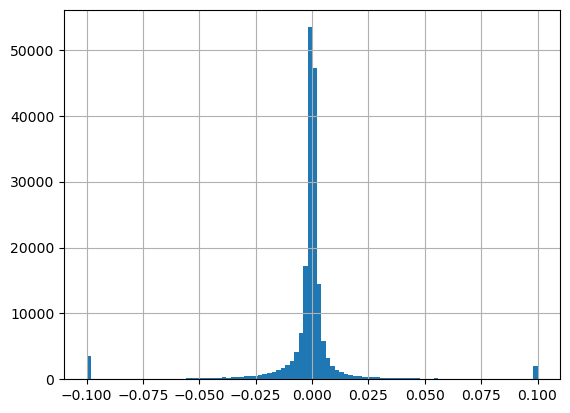

In [254]:
data['target_fee'].hist(bins=100)

In [255]:
params

{'LVR_nbtoken': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'price_diff': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'arb_pnl': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'std': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'mean_rol_amount': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'avg_gas': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'price_impact': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'rol_amountUSD': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'lambda_1min': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'rol_1min_span': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'rol_1m_trade_count': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'lambda_5min': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'rol_5min_span': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'rol_5m_trade_count': {'f_min': 0.04, 'f_max': 0.1, 'k': 1.75, 'x0': 0.75},
 'amountUSD'

<Axes: >

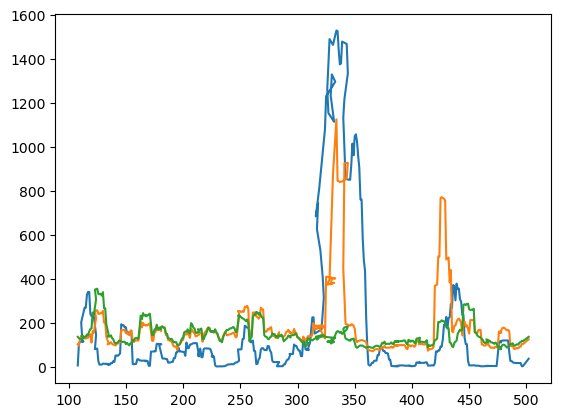

In [256]:
# We can really see that the arbitrage profit theorethical is very linked with the gas payed for transaction on the exchange
# The gas cost is higher that the profits made because we only look at arbitrage on a given pool 
# but usually uniswap alows a multicall if you want to perform a swap transaction accross multiple pools simultanously
# in this you can bundle all the swap into one transaction so you would pay for one tx instead of multiple 
# then arbitragers are also look ing for additional profits on other pools 

(data_filtered['arb_pnl']).abs().rolling(10).sum().head(400).plot()

data_filtered['tcost_usd'].rolling(10).sum().head(400).plot()

# recompute the avg_gas taking all transactions from the block even if they dont want to trade on the pool
data_filtered['avg_gas'].rolling(10).sum().head(400).plot()

<Axes: >

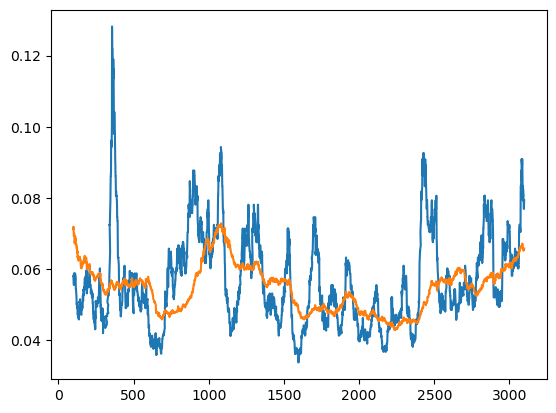

In [257]:
data_filtered['lambda_1min'].head(3000).plot()
data_filtered['lambda_5min'].head(3000).plot()

In [259]:
X = data_filtered[features]
y = data_filtered[target]

model = RandomForestRegressor(random_state=42, n_jobs=-1)

model.fit(X, y)

feature_importances = model.feature_importances_

normalized_feature_importances = feature_importances / feature_importances.sum()

features_importance_normalized = {feature: importance for feature, importance in zip(features, normalized_feature_importances)}
print("\nNormalized Feature Importances:")
for feature, importance in features_importance_normalized.items():
    print(f"{feature}: {importance:.4f}")
    
features = list(features_importance_normalized.keys())
normalized_importances = list(features_importance_normalized.values())

# Sorting features by their importances for better visualization
sorted_indices = sorted(range(len(normalized_importances)), key=lambda i: normalized_importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [normalized_importances[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances, color=plt.cm.viridis(np.linspace(0, 1, len(features))))
plt.xlabel('Normalized Feature Importance')
plt.title('Normalized Average Feature Importances Across Folds')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()



Normalized Feature Importances:
LVR_nbtoken: 0.0494
price_diff: 0.1346
arb_pnl: 0.0963
std: 0.0527
mean_rol_amount: 0.0747
avg_gas: 0.1117
price_impact: 0.0156
rol_amountUSD: 0.0716
lambda_1min: 0.0291
rol_1min_span: 0.0644
rol_1m_trade_count: 0.0000
lambda_5min: 0.0302
rol_5min_span: 0.0313
rol_5m_trade_count: 0.0001
amountUSD: 0.2381


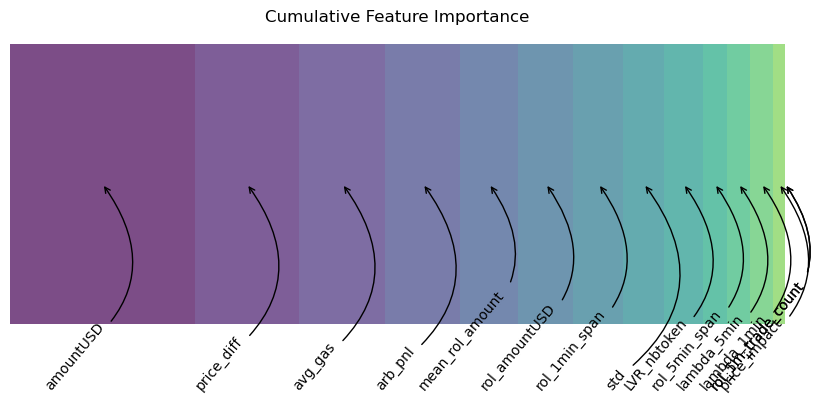

In [260]:
# Assuming 'features_importance_normalized' is your dictionary with your features and their normalized importances
features = list(features_importance_normalized.keys())
importances = list(features_importance_normalized.values())

# Sort features by their importances in descending order
sorted_indices = sorted(range(len(importances)), key=lambda i: importances[i], reverse=True)
sorted_features = [features[i] for i in sorted_indices]
sorted_importances = [importances[i] for i in sorted_indices]

# Plot setup
plt.figure(figsize=(10, 4))  # Adjust the figure size as necessary
cumulative_importances = [sum(sorted_importances[:i+1]) for i in range(len(sorted_importances))]
starts = [0] + cumulative_importances[:-1]  # Starting point for each feature's bar section

# Create a stacked bar plot with annotations
for i, feature in enumerate(sorted_features):
    plt.barh(' ', sorted_importances[i], left=starts[i], color=plt.cm.viridis(i / len(sorted_features)), alpha=0.7)
    # Annotate each bar section with the feature name
    plt.annotate(feature, 
                 xy=(starts[i] + sorted_importances[i] / 2, 0), 
                 xytext=(-20, -150),  # Adjust as needed
                 textcoords="offset points",
                 ha='center', va='bottom',
                 rotation=50,  # Adjust as needed
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.5"))

plt.xlabel('Normalized Feature Importance')
plt.title('Cumulative Feature Importance')
plt.xlim(0, 1)  # Ensure the x-axis goes from 0 to 1 to represent the full 100% of importances
plt.axis('off')  # Turn off the axis for a cleaner look
plt.show()


In [261]:
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

for f in features:    
    # here for each features the parameters of the sigmoid will be the one to calibrate
    buy_subset[f'{f}_fee']  = buy_subset[f].apply(lambda x: adjusted_sigmoid(x, params[f]['f_min'], params[f]['f_max'], params[f]['k'], params[f]['x0']))
    sell_subset[f'{f}_fee'] = -sell_subset[f].apply(lambda x: adjusted_sigmoid(-x, params[f]['f_min'], params[f]['f_max'], k, params[f]['x0']))

combined_data = pd.concat([buy_subset, sell_subset])

# Apply feature importances as weights
for f in features:
    weight = features_importance_normalized[f]
    combined_data[f'{f}_weighted_fee'] = combined_data[f'{f}_fee'] * weight

# sum weighted fees to get a combined fee
weighted_fee_columns = [f'{f}_weighted_fee' for f in features]
combined_data['combined_fee'] = combined_data[weighted_fee_columns].sum(axis=1)/100

combined_data['selling_fee'] = 0 
combined_data['buying_fee']  = 0 

combined_data.loc[combined_data['amount0'] < 0, 'selling_fee'] = combined_data['combined_fee']
combined_data.loc[combined_data['amount1'] < 0, 'buying_fee'] = combined_data['combined_fee']

combined_data['target_fee_usd'] = combined_data['target_fee'] * combined_data['amount0']


In [ ]:
# check the fee is correctly computed for each features
combined_data

,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,...,rol_1min_span_weighted_fee,rol_1m_trade_count_weighted_fee,lambda_5min_weighted_fee,rol_5min_span_weighted_fee,rol_5m_trade_count_weighted_fee,amountUSD_weighted_fee,combined_fee,selling_fee,buying_fee,target_fee_usd
99,6318.571324,-2.753365,6310.474821,0xf3e01e963796ad8ed86fc7dbce195eaa3aaf4e4a,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,414642,1.216669e+10,1.216669e-08,...,0.006552,0.0,0.000683,0.003083,0.000014,0.024173,0.000737,0.000000,0.000737,6.713662
102,1500.000000,-0.653642,1498.084492,0xfcb40a45a51a31f568ef39e0f6dfe5f3b21711df,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,303561,1.095438e+10,1.095438e-08,...,0.006552,0.0,0.000682,0.003083,0.000014,0.024173,0.000749,0.000000,0.000749,4.470694
105,1000.000000,-0.435761,998.722184,0xa6f73764fed1a058a328c0a4740053809f07875d,0xf3de3c0d654fda23dad170f0f320a92172509127,0xf3de3c0d654fda23dad170f0f320a92172509127,1.704069e+09,286452,1.196813e+10,1.196813e-08,...,0.006552,0.0,0.000682,0.003083,0.000014,0.024173,0.000750,0.000000,0.000750,3.423751
107,5424.689830,-2.363860,5417.751182,0x00903f96abe2743b81fc7fcf4874c715a3fe1c88,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.704069e+09,363346,1.127149e+10,1.127149e-08,...,0.006552,0.0,0.000681,0.003083,0.000014,0.024173,0.000775,0.000000,0.000775,8.063233
108,1000.000000,-0.435970,998.961356,0x652c814acf2334fa1cd30414b00b704986548004,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,1.704069e+09,282193,1.068151e+10,1.068151e-08,...,0.006552,0.0,0.000681,0.003083,0.000014,0.024173,0.000727,0.000000,0.000727,4.544630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187217,-150.000000,0.065775,149.978583,0xd132becd2e0a3c5d9d5b4c0fbdcc316ddf1d6e00,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,641134,2.110782e+10,2.110782e-08,...,-0.000655,-0.0,-0.000608,-0.000308,-0.000001,-0.002417,-0.000126,-0.000126,0.000000,6.958028
187218,-47438.602771,20.800000,47429.790306,0x0b7c57a13b1fcf185cbdf40382c721429b4352f0,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706745e+09,345666,2.350034e+10,2.350034e-08,...,-0.000655,-0.0,-0.000608,-0.000308,-0.000001,-0.002417,-0.000117,-0.000117,0.000000,34.402387
187220,-4281.501296,1.877463,4280.921566,0xf865067a5b9672f11af8514440d9111afd05d040,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706746e+09,606426,2.448898e+10,2.448898e-08,...,-0.000655,-0.0,-0.000608,-0.000308,-0.000001,-0.002417,-0.000164,-0.000164,0.000000,3.856220
187221,-16804.135320,7.369011,16802.205053,0x4066e9bd5618373d2da7a1cb7bba03ef800875ee,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,0x6719c6ebf80d6499ca9ce170cda72beb3f1d1a54,1.706746e+09,217474,8.602831e+10,8.602831e-08,...,-0.000655,-0.0,-0.000608,-0.000308,-0.000001,-0.002417,-0.000147,-0.000147,0.000000,-28.852054


In [262]:
metrics = combined_data.resample('1Min', on='time_dex').agg({
    'price_dex'           : 'ohlc',
    'amount0'             : 'sum',
    'amount1'             : 'sum',
    'amountUSD'           : 'sum',
    'price_diff'          : 'last',
    'arb_pnl'             : 'sum',
    'price_impact'        : 'sum', # or mean maybe
    'lambda_5min'         : 'last',
    'lambda_1min'         : 'last',
    'impermanent_loss'    : 'sum',
    'tcost_usd'           : 'sum',
    'avg_gas'             : 'sum',
    'target_fee_usd'      : 'sum',
    'combined_fee'        : 'last',
    'selling_fee'         : 'last',
    'buying_fee'          : 'last',
})
metrics.columns = metrics.columns.droplevel(0)
metrics = metrics.rename(columns={'amountUSD': 'volumeUSD'})
metrics['1m_volumeUSD'] = metrics['volumeUSD'].rolling(window=60).sum()

metrics['future_close'] = metrics['close'].shift(-60)
metrics = metrics.dropna()

metrics['markout'] = metrics.apply(lambda x: calculate_markout(d=np.sign(x['amount0']), v=x['volumeUSD'], f=x['future_close'], p=x['close']), axis=1)

pool_fee_rate = 0.05/100

metrics['trade_direction'] = np.sign(metrics['amount0'])
metrics['cfee'] = pool_fee_rate * metrics['volumeUSD']
metrics['dfee'] = metrics['combined_fee'].abs() * metrics['volumeUSD']

metrics['cpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['cfee'].abs()
metrics['dpnl'] = metrics['close'].shift(-1) - metrics['close'] + metrics['dfee'].abs()

metrics['cfee_cumul'] = metrics['cfee'].cumsum()
metrics['dfee_cumul'] = metrics['dfee'].cumsum()
metrics['avg_7m_cfee'] = (metrics['volumeUSD'] * pool_fee_rate).rolling(window=7).mean()

metrics['cpnl_5m_positive'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['cpnl_5m_negative'] = metrics['cpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['c%_toxic_flow_ma_7m'] = (metrics['cpnl_5m_negative'].abs() / (metrics['cpnl_5m_negative'] + metrics['cpnl_5m_positive'])).rolling(window=7).mean()

metrics['dpnl_5m_positive'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x>0]))
metrics['dpnl_5m_negative'] = metrics['dpnl'].rolling(window=5).apply(lambda x: np.sum(x[x<0]))
# Calculate a 7 min ma of percent toxic flow:
metrics['d%_toxic_flow_ma_7m'] = (metrics['dpnl_5m_negative'].abs() / (metrics['dpnl_5m_negative'] + metrics['dpnl_5m_positive'])).rolling(window=7).mean()

metrics.dropna()

,open,high,low,close,amount0,amount1,volumeUSD,price_diff,arb_pnl,price_impact,...,dpnl,cfee_cumul,dfee_cumul,avg_7m_cfee,cpnl_5m_positive,cpnl_5m_negative,c%_toxic_flow_ma_7m,dpnl_5m_positive,dpnl_5m_negative,d%_toxic_flow_ma_7m
time_dex,,,,,,,,,,,,,,,,,,,,,
2024-01-01 01:35:00,2300.117792,2300.347804,2300.117792,2300.117792,1506.119376,-0.653850,4.368604e+03,1.452208,-0.757648,0.002440,...,3.466976,2.935182e+02,2.511056e+02,27.168543,131.615099,0.0,0.0,114.312537,0.0,0.0
2024-01-01 01:36:00,2300.577839,2303.109740,2300.577839,2301.728358,194586.273641,-84.371293,9.437273e+05,3.271642,63.178711,29.438008,...,392.992557,7.653818e+02,6.443283e+02,93.410317,602.331433,0.0,0.0,506.419124,0.0,0.0
2024-01-01 01:37:00,2303.570385,2304.722401,2301.268081,2301.498208,-18650.703552,8.799881,3.196956e+06,1.821792,838.954432,192.909729,...,1324.513140,2.363860e+03,1.967000e+03,314.138088,2146.442390,0.0,0.0,1782.436537,0.0,0.0
2024-01-01 01:38:00,2302.418945,2303.340051,2301.268081,2303.340051,322041.933132,-139.662842,1.031106e+06,1.329949,-112.467972,41.366099,...,437.637214,2.879413e+03,2.404637e+03,387.756033,2659.221314,0.0,0.0,2217.605511,0.0,0.0
2024-01-01 01:39:00,2303.340051,2303.340051,2303.340051,2303.340051,-572.968411,0.249118,1.562929e+03,-0.160051,-0.271351,0.000213,...,0.702007,2.880194e+03,2.405339e+03,379.837828,2592.082796,0.0,0.0,2159.311894,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 22:54:00,2284.302396,2284.302396,2284.302396,2284.302396,5178.985886,-2.265660,7.210286e+03,0.717604,-2.736997,0.007036,...,3.174272,3.234569e+06,3.808436e+06,35.619326,162.918697,0.0,0.0,141.512752,0.0,0.0
2024-01-31 22:55:00,2284.302396,2284.530826,2284.302396,2284.302396,-3401.772389,1.493047,1.749350e+04,0.587604,1.612475,0.034422,...,6.029803,3.234578e+06,3.808443e+06,31.786549,150.023334,0.0,0.0,130.429224,0.0,0.0
2024-01-31 22:56:00,2284.302396,2284.302396,2282.932294,2282.932294,-157757.196816,69.121671,1.721966e+05,-0.882294,-60.592189,6.087215,...,147.751420,3.234664e+06,3.808590e+06,36.562443,219.616645,0.0,0.0,262.849367,0.0,0.0


<Axes: xlabel='time_dex'>

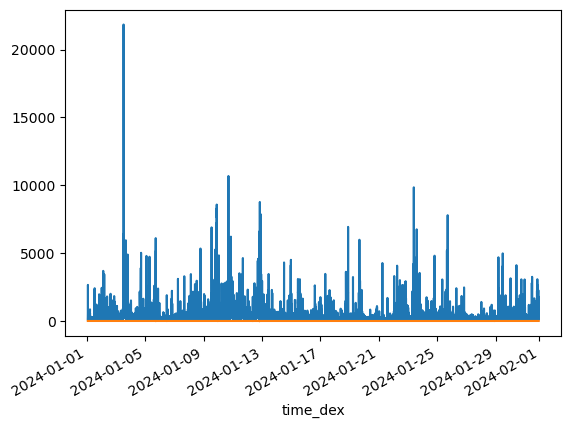

In [ ]:
metrics['cpnl_5m_positive'].plot()
metrics['cpnl_5m_negative'].plot()

<Axes: xlabel='time_dex'>

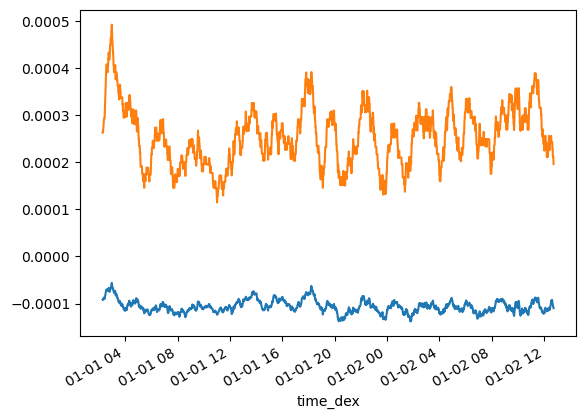

In [ ]:
metrics['selling_fee'].rolling(50).mean().head(2000).plot()
metrics['buying_fee'].rolling(50).mean().head(2000).plot()

In [263]:
add_per = (metrics['dpnl'] - metrics['cpnl']).sum()/current_liquidity_usd
print('Additional profits of the dynamic fee over the constant fee model: ', round(add_per*100,2), '%')
print('')
price_impact_improvments = 1 - 1/(1+add_per)
print('Price impact of the dynamic fee model decreased by: ', round(price_impact_improvments*100,2), '%')
print('')
print(f"The average constant fees is: {0.05}")
average_fee_positive = combined_data[combined_data['amount1'] > 0]['combined_fee'].mean()
average_fee_negative = combined_data[combined_data['amount1'] < 0]['combined_fee'].mean()

print(f"The average dynamic selling fees is: {round(average_fee_positive, 2)}")
print(f"The average dynamic buying  fees is: {round(average_fee_negative, 2)}")
print('')
print(f"The total constant fees are: {round(metrics['cfee'].abs().sum(), 2)}")
print(f"The total dynamic  fees are: {round(metrics['dfee'].abs().sum(), 2)}")
print('')
print(f"The total pnl with c are: {round(metrics['cpnl'].sum(), 2)}")
print(f"The total pnl with d are: {round(metrics['dpnl'].sum(), 2)}")
print('')
print(f"The % of toxic pnl flow in constant fee: {metrics['c%_toxic_flow_ma_7m'].sum().round(2)}")
print(f"The % of toxic pnl flow in dynamic  fee: {metrics['d%_toxic_flow_ma_7m'].sum().round(2)}")
print('')
print('The 1 min markout pnl is: ', round(metrics['markout'].sum(), 2))
print('')
print('The impermanent loss is : ', round(metrics['impermanent_loss'].sum(), 2))
print('')
print('Average tcost_usd     : ', round(metrics['tcost_usd'].mean(), 2))
print('Average target_fee_usd: ', round(metrics['target_fee_usd'].mean(), 2))
print('')
print('Average combined_fee  : ', round(metrics['combined_fee'].abs().mean(), 2))
weighted_fee = (combined_data['amountUSD'] * combined_data['combined_fee'].abs())/combined_data['amountUSD'].sum()
print('Average weighted_fee  : ', round(weighted_fee.mean(), 5))
print('Average selling_fee   : ', round(metrics['selling_fee'].abs().mean(), 2))
print('Average buying_fee    : ', round(metrics['buying_fee'].abs().mean(), 2))

weighted_buying_fee = ((combined_data[combined_data['amount1'] < 0]['buying_fee'] * combined_data[combined_data['amount1'] < 0]['amountUSD']) / combined_data[combined_data['amount1'] < 0]['amountUSD'].sum()).sum()
weighted_selling_fee = ((combined_data[combined_data['amount1'] > 0]['selling_fee'] * combined_data[combined_data['amount1'] > 0]['amountUSD']) / combined_data[combined_data['amount1'] > 0]['amountUSD'].sum()).sum()

print('Weighted average buying_fee: ', round(weighted_buying_fee, 2))
print('Weighted average selling_fee: ', round(weighted_selling_fee, 2))

# only 9% of the fees that we quote are in the range of the fee the arbitrager will be willing to pay
accuracy = (metrics['avg_gas'] + metrics['dfee'].abs() < metrics['tcost_usd']).mean()

print(f'{accuracy*100:.2f}% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay')
print('Average accuracy of the fee: ', round(accuracy*100, 2))

# can we know whats gonna be the price impact after this dynamic fee:
# we need to now what will be the liquidity in such pools at the permanent regime 
# this will depend on the profitability (returns of LP) of LP. 
# In average the liquidty is provided in a pool such that the returns are the same as a constant pool 
# we can then match the liquidity corresponding to this profitability and find the price impact at a given liquidity level for a given amount to swap

Additional profits of the dynamic fee over the constant fee model:  0.35 %

Price impact of the dynamic fee model decreased by:  0.34 %

The average constant fees is: 0.05
The average dynamic selling fees is: -0.0
The average dynamic buying  fees is: 0.0

The total constant fees are: 3234906.31
The total dynamic  fees are: 3808807.78

The total pnl with c are: 3234821.32
The total pnl with d are: 3808730.68

The % of toxic pnl flow in constant fee: 26.11
The % of toxic pnl flow in dynamic  fee: 21.14

The 1 min markout pnl is:  2014993485.36

The impermanent loss is :  -0.01

Average tcost_usd     :  169.17
Average target_fee_usd:  390.38

Average combined_fee  :  0.0
Average weighted_fee  :  0.0
Average selling_fee   :  0.0
Average buying_fee    :  0.0
Weighted average buying_fee:  0.0
Weighted average selling_fee:  -0.0
6.82% of the dynamic fees are in the range of the constant fee the arbitrager will be willing to pay
Average accuracy of the fee:  6.82


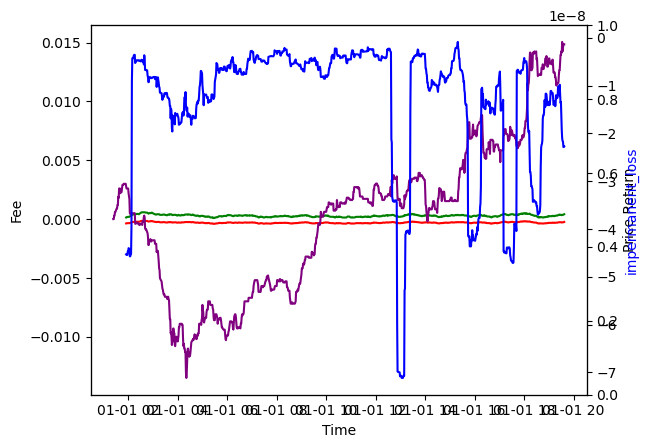

In [264]:
# after aggregating the swap on a minute level here is the time series of the fee we charge
n = 1000
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax3 = ax1.twinx()
ax1.plot(metrics['buying_fee'].rolling(30).mean().head(n), color='green')
ax1.plot(metrics['selling_fee'].rolling(30).mean().head(n), color='red')

ax1.plot(metrics['close'].pct_change().cumsum().head(n), color='purple')
ax2.plot(metrics['impermanent_loss'].rolling(30).mean().head(n), color='blue')

ax1.set_xlabel('Time')
ax1.set_ylabel('Fee', color='black')
ax2.set_ylabel('Price Return', color='black')
ax3.set_ylabel('impermanent_loss', color='blue')
plt.show()


In [ ]:
# plot correlation of the dynamic fee with the factore we consider in the model
# plot also the temporal rolling graphs of the features and the fees to see they mve together

In [ ]:
# calib k:
from scipy.optimize import minimize

def buy_fee(x,  f_min, f_max, w_buy):
    return min(f_max, f_min + w_buy * max(0, x))

def sell_fee(x,  f_min, f_max, w_sell):
    return min(f_max, f_min - w_sell * min(0, x))

def adjusted_sigmoid(x, f_min, f_max, k, x0):
    return f_min + (f_max - f_min) / (1 + np.exp(-k * (x - x0)))

def cost_function_buy(k, delta_ps, f_min, f_max, w_buy, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([buy_fee(x,  f_min, f_max, w_buy) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)

def cost_function_sell(k, delta_ps, f_min, f_max, w_sell, x0):
    sigmoid_fees = np.array([adjusted_sigmoid(-x, f_min, f_max, k, x0) for x in delta_ps])
    linear_fees = np.array([sell_fee(x,  f_min, f_max, w_sell) for x in delta_ps])
    return np.sum((sigmoid_fees - linear_fees) ** 2)

In [ ]:
features

['LVR_nbtoken',
 'price_diff',
 'arb_pnl',
 'std',
 'mean_rol_amount',
 'avg_gas',
 'price_impact',
 'rol_amountUSD',
 'lambda_1min',
 'rol_1min_span',
 'rol_1m_trade_count',
 'lambda_5min',
 'rol_5min_span',
 'rol_5m_trade_count',
 'amountUSD']

Optimized k for buying fees : 0.23398531868910866
Optimized k for selling fees: 0.02456246338355273


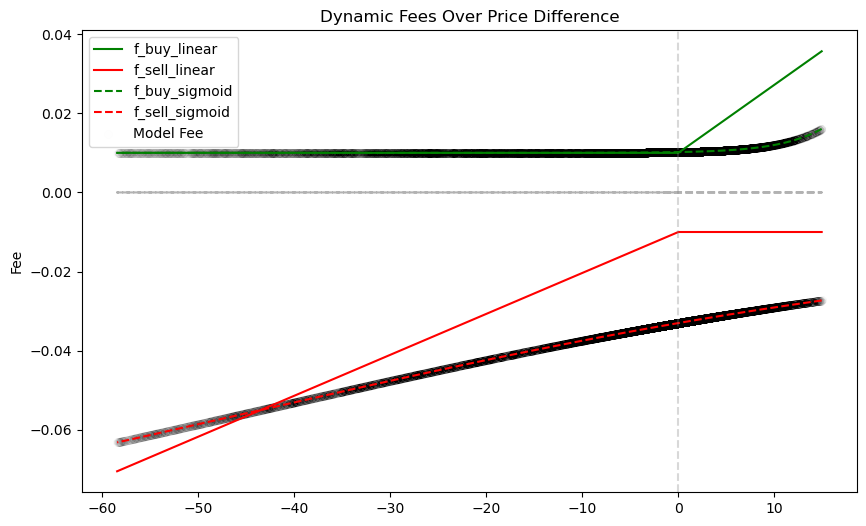

In [265]:
feat = 'arb_pnl' # 'arb_pnl'
f_min  = 0.01
f_max  = 0.1
low_q  = 0.05
high_q = 0.95


scale_min = data_filtered[feat].quantile(high_q)
scale_max = data_filtered[feat].quantile(low_q)
delta_p = pd.DataFrame({'delta_p': np.linspace(scale_min, scale_max, 1000)})

## !! the price difference is stationnary because we cans stipulate the the dex and cex price are stationnary wich makes total sense 
# cause they are the same asset and arrbitragers always move to remove the differnce
# Then we dont really need to care of using the zscore also because we will redo a different calibration for a different pair 
# (so we dont need to normalize the time series of the difference)


# Segment the data based on 'amount1'
buy_subset = data_filtered[data_filtered['amount1'] < 0].copy()
sell_subset = data_filtered[data_filtered['amount1'] > 0].copy()

if len(sell_subset[sell_subset[feat]<0])>0:
    sell_max_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]<0][feat].quantile(high_q)
else :
    sell_max_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(low_q)
    sell_min_fee_q = sell_subset[sell_subset[feat]>0][feat].quantile(high_q)
    
if len(buy_subset[buy_subset[feat]>0])>0:
    buy_max_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]>0][feat].quantile(high_q)
else:
    buy_max_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(low_q)
    buy_min_fee_q  = buy_subset[buy_subset[feat]<0][feat].quantile(high_q)

w_buy  = np.abs((f_max-f_min)/buy_min_fee_q)
w_sell = np.abs((f_max-f_min)/sell_max_fee_q)

x0_sell = np.abs(sell_max_fee_q/2)
x0_buy = np.abs(buy_min_fee_q/2)

delta_ps = np.linspace(scale_min, scale_max, 1000)
result_buy  = minimize(cost_function_buy,  1, args=(delta_ps, f_min, f_max, w_buy,  x0_buy))
result_sell = minimize(cost_function_sell, 1, args=(delta_ps, f_min, f_max, w_sell, x0_sell))

k_buy  = result_buy.x[0]
k_sell = result_sell.x[0]

print(f"Optimized k for buying fees : {k_buy}")
print(f"Optimized k for selling fees: {k_sell}")

# Apply the fees
buy_subset['model_fee'] = buy_subset[feat].apply(lambda x: adjusted_sigmoid(x, f_min, f_max, k_buy, x0_buy))
sell_subset['model_fee'] = -sell_subset[feat].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell))

combined_data = pd.concat([buy_subset, sell_subset])

# plot the fees and the model fee
plt.figure(figsize=(10, 6))

plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: min(f_max, f_min + w_buy * max(0, x))),  label='f_buy_linear', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: min(f_max, f_min - w_sell * min(0, x))), label='f_sell_linear', color='red')
plt.plot(delta_p['delta_p'],  delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(x,  f_min, f_max, k_buy,  x0_buy)),  label='f_buy_sigmoid',  linestyle='--', color='green')
plt.plot(delta_p['delta_p'], -delta_p['delta_p'].apply(lambda x: adjusted_sigmoid(-x, f_min, f_max, k_sell, x0_sell)), label='f_sell_sigmoid', linestyle='--', color='red')

filtered_plot = (combined_data[feat] >= combined_data[feat].quantile(low_q)) & (combined_data[feat] <= combined_data[feat].quantile(high_q))
plt.scatter(combined_data[filtered_plot][feat], combined_data[filtered_plot]['model_fee'], alpha=0.005, color='black', label='Model Fee')

plt.plot(combined_data[filtered_plot][feat], [0]*len(combined_data[filtered_plot]), linestyle='--', alpha=0.3, color='black')
plt.axvline(0, color='gray', linestyle='--', alpha=0.3) 

plt.ylabel('Fee')
plt.legend()
plt.title('Dynamic Fees Over Price Difference')
plt.show()

In [ ]:
## look in average the final combined fee, how much greater than the base fee it is

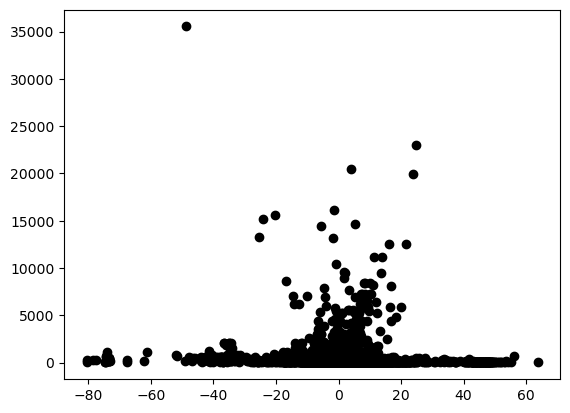

In [ ]:
plt.scatter(combined_data['price_diff'], combined_data['tcost_usd'], alpha=1, color='black', label='Model Fee')
